# Computation of transverse-Ising superoperators

In [365]:
include("notebook_preamble.jl");

**TODO:** Redefine spin operators and the rest to depend on $N$ and maybe $\lambda$, so that we can look at what happens as those parameters are varied.

## Utility functions

In [366]:
trnorm(op) = tracenorm(dense(op))
acomm(x, y) = x*y + y*x
matriximage(A) = Gray.(1 .- abs.(A))
matriximage(A::Operator) = matriximage(dense(A).data)

function acomm_table(a, b, N, image)
    A = Matrix{Float64}(undef, N, N)
    for i in 1:N, j in i:N
        A[j, i] = trnorm(acomm(a(i), b(j))) / 2^N
    end
    L = LowerTriangular(A)
    image ? matriximage(L) : L
end

function acomm_tables(c, N=Int(log2(size(c(1))[1])); image=true)
    ct = dagger ∘ c
    acomms = [
        acomm_table(ct, c, N, image),
        acomm_table(c, c, N, image),
        acomm_table(ct, ct, N, image),
    ]
    if image
        hcat(acomms...)
    else
        for ac in acomms
            display(ac)
        end
    end
end

tpow(x, n) = ⊗(repeat([x], n)...);

## Spins

First, we set up the spin-1/2 sites and Pauli operators.

In [367]:
sb = SpinBasis(1//2)
sx, sy, sz, sp, sm = sigmax(sb), sigmay(sb), sigmaz(sb), sigmap(sb), sigmam(sb)
up, down = spinup(sb), spindown(sb)
ψx = eigenstates(dense(sx))[2][1];

## Ising model

To create a $N$-site spin loop, we need to construct the basis for the loop and operators for each site.

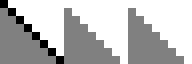

In [368]:
N = 8
sB = tpow(sb, N)
I = identityoperator(sB)
site(i, op) = embed(sB, (i-1)%N + 1, op) # Periodic boundary
acomm_tables(i -> site(i, sm))

We now construct the transverse-field Ising Hamiltonian (Pfeuty)
$$
\frac{\ham}{\Gamma}
= - \sum_i \opr{S}_z^i
- \frac{J}{\Gamma} \sum_{i=1}^N \opr{S}_i^x \opr{S}_{i+1}^x ,
$$
where $2\lambda = J / \Gamma$.

In [369]:
λ = 0.5 # Pfeuty with Γ=1, so 
Hs = -sum(site(i, sz)/2 + 2λ*site(i, sx)*site(i+1, sx)/4 for i in 1:N);

## Fermion definitions

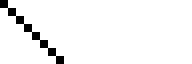

In [370]:
k(m, N=N) = 2π*(m-1)/N - π*(N - (N%2))/N; # for m in 1:N
function c(i) # for i in 1:N
    i = (i-1)%N + 1 
    A = -(i == 1
        ? I
        : prod(-site(j, sz) for j in 1:(i-1)))
    A * site(i, sm)
end
ct(i) = dagger(c(i))
acomm_tables(c)

Verify that the inverse Jordan-Wigner transformation reproduces all the $\pauli_i^x$:

In [371]:
csx(i) = -(i == 1 ? I : prod(I - 2*ct(j)*c(j) for j in 1:(i-1))) * (ct(i) + c(i))
[csx(i) - site(i, sx) for i in 1:N]' .|> trnorm

1×8 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

The Jordan-Wigner transformed Hamiltonian:

In [372]:
L = sum(ct(i)*c(i) for i in 1:N)
Hend = (λ/2) * (ct(N) - c(N))*(ct(1) + c(1))*((sparse ∘ exp ∘ dense)(im*π*L) + I);
Hc = I*(N/2) + Hend - sum(
    ct(i)*c(i) + (λ/2) * (ct(i) - c(i))*(ct(i+1) + c(i+1))
    for i in 1:N);

In [373]:
trnorm(Hs - Hc) / 2^N

2.4308524276541633e-16

It looks like the trace norm of the boundary term relative to that of the whole Hamiltonian diminishes with increasing $N$. But does this imply that it may be dropped?

In [374]:
trnorm(Hend) / trnorm(Hs)

0.19610389063966407

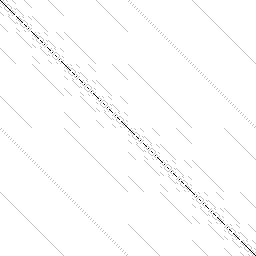

In [375]:
matriximage(Hs - Hend)

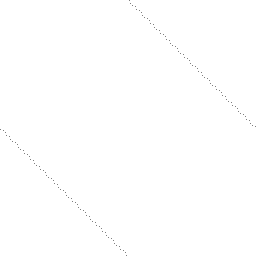

In [376]:
matriximage(Hend)

In [377]:
Hs.data .|> abs |> extrema

(0.0, 4.0)

### Striff

**Hyp:** The diagonalization of the Fourier-transformed fermion operator Hamiltonian is incorrect. Esp. for the negative eigenvalue.

My $\lambda$ differs from Pfeuty's:

In [482]:
λS = -1 / λ

-2.0

First, we define the Fourier-transformed fermion operators and verify that the corresponding Hamiltonian is correct.

In [483]:
C(k) = sum(exp(-im*k*i) * c(i) for i in 1:N) / √N
Ct(k) = dagger(C(k))
Hk(k) = [
    λS - cos(k)  -im*sin(k)
    im*sin(k)    cos(k) - λS
]
vk(k) = [C(k); Ct(-k)]
vkt(k) = [Ct(k) C(-k)];

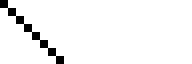

In [484]:
acomm_tables(C∘k)

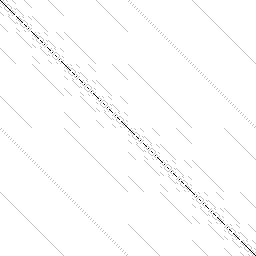

In [485]:
HC = sum((vkt(k(m))*Hk(k(m))*vk(k(m)))[1] for m in 1:N) / 4 # factor?
matriximage(HC)

In [486]:
HC.data .|> abs |> extrema

(0.0, 3.9999999999999996)

In [500]:
(trnorm((Hs - Hend) - HC), trnorm(Hs - HC)) ./ 2^N

(4.630581115863444e-16, 0.2500000000000001)

Now, we define $E_k$ and the operators $\opr{\eta}_k = \opr{\eta}_k^+$.

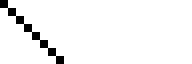

In [488]:
E(m, N=N) = √(λS^2 - 2λS*cos(k(m, N)) + 1)
aS(m) = ((N%2 == 0 && m == 1) || m == 1 + floor(N//2) ? 0 :
    -im*sin(k(m)) / √(2E(m)*(E(m) + cos(k(m)) - λS)))
bS(m) = ((N%2 == 0 && m == 1) || m == 1 + floor(N//2) ? 1 :
    √((E(m) + cos(k(m)) - λS) / (2E(m))))
ηS(m) = aS(m)*C(k(m)) + bS(m)*Ct(-k(m))
ηSt(m) = dagger(ηS(m))
acomm_tables(ηS)

We'll also try with the form that includes $\opr{\eta}_k^-$, too.

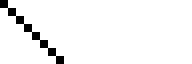

In [554]:
amS(m) = ((N%2 == 0 && m == 1) || m == 1 + floor(N//2) ? 0 :
    -im*sin(k(m)) / √(2E(m)*(E(m) - cos(k(m)) + λS)))
bmS(m) = -((N%2 == 0 && m == 1) || m == 1 + floor(N//2) ? 1 :
    √((E(m) - cos(k(m)) + λS) / (2E(m))))
ηmS(m) = amS(m)*C(k(m)) + bmS(m)*Ct(-k(m))
ηmSt(m) = dagger(ηmS(m))
acomm_tables(ηmS)

Check if the Striff $\opr{\eta}_k^\pm$ Hamiltonian is correct:

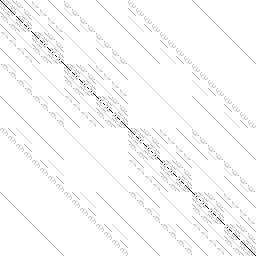

In [490]:
HηpmS = (1/3) * (sum(E(m)*ηSt(m)*ηS(m) for m in 1:N) - sum(E(m)*ηmSt(m)*ηmS(m) for m in 1:N)) # factor?
matriximage(HηpmS)

In [491]:
HηpmS.data .|> abs |> extrema

(0.0, 3.999999999999999)

In [492]:
(trnorm((Hs - Hend) - HηpmS), trnorm(Hs - HηpmS)) ./ 2^N

(1.1933452587283473, 1.1878736812244224)

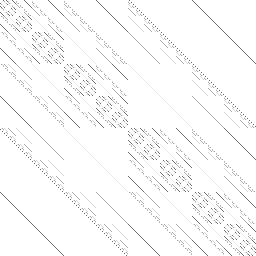

In [499]:
(Hs - Hend) - HηpmS |> matriximage

Check if the Striff $\opr{\eta}_k$ Hamiltonian is correct:

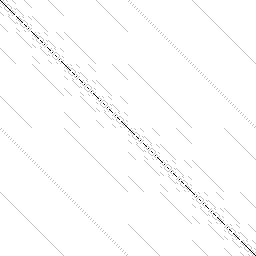

In [493]:
E0S = -sum(E(m) for m in 1:N) / 2;
HηS = (1/2)*(sum(E(m)*ηSt(m)*ηS(m) for m in 1:N) + E0S*I) # factor?
matriximage(HηS)

In [494]:
HηS.data .|> abs |> extrema

(0.0, 3.9999999999999996)

In [495]:
(trnorm((Hs - Hend) - HηS), trnorm(Hs - HηS)) ./ 2^N

(0.7910533905932737, 0.802127402334464)

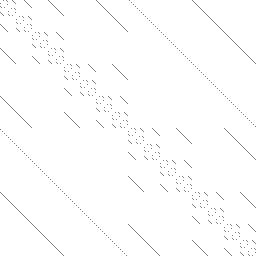

In [498]:
(Hs - Hend) - HηS |> matriximage

Solve for the $\opr{\eta}_k^\pm$:

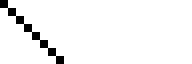

In [737]:
Heigs = [eigen(Hk(k(m))) for m in 1:N]
EC(m) = Heigs[m].values[2] # Positive energy
# ηC(m) = ([C(k(m)) Ct(-k(m))] * Heigs[m].vectors[:,2])[1]
# ηmC(m) = ([C(k(m)) Ct(-k(m))] * Heigs[m].vectors[:,1])[1]
ηC(m)  = (Heigs[m].vectors)'[1,2] * C(k(m)) + (Heigs[m].vectors)'[2,2] * Ct(-k(m))
ηmC(m) = (Heigs[m].vectors)'[1,1] * C(k(m)) + (Heigs[m].vectors)'[2,1] * Ct(-k(m))
ηCt(m)  = dagger(ηC(m))
ηmCt(m) = dagger(ηmC(m))
acomm_tables(ηC)

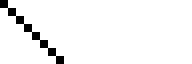

In [738]:
acomm_tables(ηmC)

In [739]:
[ηC(m) - ηS(m) for m in 1:N]' .|> trnorm

1×8 Array{Float64,2}:
 7.83774e-15  44.8265  41.5897  23.062  0.0  23.062  41.5897  44.8265

In [740]:
[ηmC(m) - ηmS(m) for m in 1:N]' .|> trnorm

1×8 Array{Float64,2}:
 256.0  44.8265  41.5897  23.062  256.0  254.959  252.599  252.045

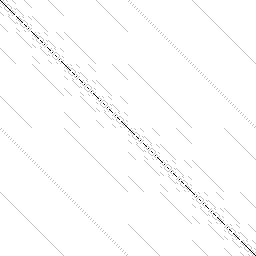

In [741]:
HηC = sum(EC(m) * (ηCt(m)*ηC(m) - ηmCt(m)*ηmC(m)) for m in 1:N) / 4 # factor? (prop. from C)
matriximage(HηC)

In [742]:
HηC.data .|> abs |> extrema

(0.0, 3.999999999999999)

In [743]:
(trnorm((Hs - Hend) - HηC), trnorm(Hs - HηC)) ./ 2^N

(0.5593592167691146, 0.6017922181450926)

We may now construct the vacuum state from the sum of number operators.

In [497]:
NηS = sum(ηSt(m)*ηS(m) for m in 1:N)
vacS = eigenstates(NηS, 1, info=false)[2][1] # Indices select first eigenstate
((ηSt(1)*ηS(1) + ηSt(2)*ηS(2)) - 2*I) * (ηSt(1) * ηSt(2) * vacS) |> norm

5.110974530065956e-16

### Pfeuty

Pfeuty: $\eta$'s do not satisfy the CARs? Typo, or **problem**?

In [393]:
Λ(m) = √(λ^2 + 2λ*cos(k(m)) + 1)
ϕ(k, i) = √(2/N) * (k > 0 ? sin(k*i) : cos(k*i))
ψ(k, i) = -((1 + λ*cos(k))*ϕ(k, i) + λ*sin(k)*ϕ(-k, i)) / Λ(k)
a(m, i) = (ϕ(k(m), i) + ψ(k(m), i)) / 2
b(m, i) = (ϕ(k(m), i) - ψ(k(m), i)) / 2
η(m) = sum(a(m, i)*c(i) + b(m, i)*ct(i) for i in 1:N)
ηt(m) = dagger(η(m));

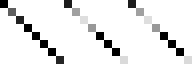

In [394]:
acomm_tables(η)

Check if the Pfeuty Hamiltonian is correct:

In [395]:
E0 = -sum(Λ(m) for m in 1:N) / 2;
Hη = sum(Λ(m)*ηt(m)*η(m) for m in 1:N) + E0*I;

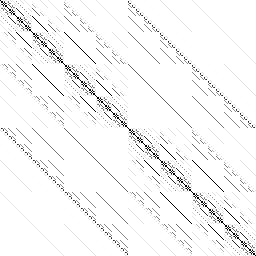

In [396]:
(Hs - Hend) - Hη |> matriximage

In [397]:
(trnorm((Hs - Hend) - Hη), trnorm(Hs - Hη)) ./ 2^N

(6.119669832517357, 6.119669832517357)

## Starting from the many-body basis instead

In [238]:
f = NLevelBasis(N) # "Levels" 1 to N are indices of k's
mbb = ManyBodyBasis(f, fermionstates(f, [0:N...]))
ηmb(m) = destroy(mbb, m)
ηtmb(m) = create(mbb, m)
Hf = diagonaloperator(f, @. Λ(k(1:N)) + E0)
Hmb = manybodyoperator(mbb, Hf);

In [239]:
A = reshape([a(m, i) for i in 1:N for m in 1:N], (N, N))
B = reshape([b(m, i) for i in 1:N for m in 1:N], (N, N))
η2c = inv([A B; conj(B) conj(A)]);

In [240]:
ηmbs = [[ηmb(m) for m in 1:N]; [ηtmb(m) for m in 1:N]]
cmbs = η2c * ηmbs
cmb(i) = cmbs[i];
cmbt(i) = cmbs[i+N];

In [241]:
[cmbt(i) - dagger(cmb(i)) for i in 1:N] .|> dense .|> tracenorm

8-element Array{Float64,1}:
 8.276191610228936e-14
 8.217185201225568e-14
 7.420665142989512e-14
 9.820039996621008e-14
 8.073334107241556e-14
 6.175135788873238e-14
 7.632354211795359e-14
 6.348397547880297e-14

It looks like `create` and `destroy` do not change the signs of occupation states, and thus do not anticommute:

In [242]:
ηmb(1).data .|> real |> extrema

(0.0, 1.0)

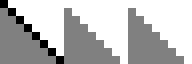

In [243]:
acomm_tables(ηmb)

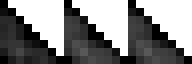

In [244]:
acomm_tables(cmb)

## Energy spacings

In [245]:
using IntervalArithmetic
setformat(:midpoint);

Note that `ΔEs` generally double-counts due to parity symmetry.

In [246]:
function ΔEs(NE)
    Eks = (m -> E(@interval(m), NE)).(1:NE)
    diffweights = Iterators.product(repeat([[-1,0,1]], NE)...)
    Ediffs = (abs(w ⋅ Eks) for w in diffweights)
    Ediffs = Ediffs ./ abs(-(extrema(Ediffs)...))
    Ediffs |> collect |> vec |> sort
end
;

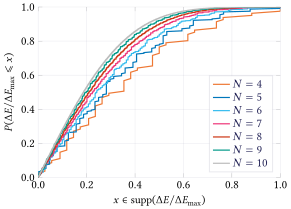

In [247]:
NE = 4
ΔEplot = plot(mid.(ΔEs(NE)), 0:1//3^NE:1-eps(),
    label=latexstring("N = $NE"),
    xlim=(0, 1),
    ylim=(0, 1),
    key=:bottomright,
    xlabel=L"x \in \mathrm{supp}(\Delta E/\Delta E_\text{max})",
    ylabel=L"P(\Delta E/\Delta E_\text{max} \leqslant x)")
for NE in 5:10
    plot!(ΔEplot, mid.(ΔEs(NE)), 0:1//3^NE:1-eps(), label=latexstring("N = $NE"))
end
ΔEplot

As expected, the density approaches a truncated normal distribution.

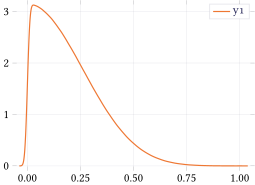

In [248]:
using KernelDensity
ΔE_kde = kde(mid.(ΔEs(12)))
plot(ΔE_kde.x, ΔE_kde.density)

This rigorously shows that the smallest $\Delta E$ is either within the first interval (nonzero) or the second interval (very close to zero).

In [249]:
[NE => foldr((x, (m, z)) -> 0 ∈ x ? (m, x ∪ z) : (min(x, m), z), ΔEs(NE), init=(@interval(Inf), @interval(0))) for NE in 2:15]

14-element Array{Pair{Int64,Tuple{Interval{Float64},Interval{Float64}}},1}:
  2 => (0.25 ± 5.55112e-17, 0 ± 0)
  3 => (0.0717968 ± 1.80412e-16, 1.03051e-16 ± 1.03052e-16)
  4 => (0.027864 ± 7.28584e-17, 5.24176e-17 ± 5.24177e-17)
  5 => (0.0149333 ± 8.84709e-17, 6.25437e-17 ± 6.25438e-17)
  6 => (0.00676561 ± 8.93383e-17, 1.04446e-16 ± 1.04446e-16)
  7 => (0.00492663 ± 9.1073e-17, 8.94574e-17 ± 8.94575e-17)
  8 => (8.75569e-05 ± 8.4866e-17, 6.52487e-17 ± 6.52487e-17)
  9 => (0.000111021 ± 1.21851e-16, 1.56578e-16 ± 1.56578e-16)
 10 => (0.000484994 ± 8.89588e-17, 1.0961e-16 ± 1.09611e-16)
 11 => (0.000260287 ± 1.94777e-16, 1.66072e-16 ± 1.66073e-16)
 12 => (4.47363e-05 ± 1.13123e-16, 1.34836e-16 ± 1.34837e-16)
 13 => (2.69225e-05 ± 1.96756e-16, 1.76658e-16 ± 1.76659e-16)
 14 => (6.73035e-07 ± 1.60313e-16, 1.67768e-16 ± 1.67769e-16)
 15 => (1.19663e-07 ± 1.53104e-16, 1.67022e-16 ± 1.67023e-16)

From the plot, we can derive an approximate lower bound for the smallest energy spacing. From the small $N$ plots, it is clear that the energy differences are not uniformly separated. However, the \textsc{cdf} (from sorted indices) is uniformly spaced. Since we have computed $3^N$ energy differences, we may then expect the typical spacing between $\Delta E$ values at $x$ to be $Q'(x) 3^{-N}$, where $Q(x)$ is the quantile function (inverse \textsc{cdf}). Suppose that for large $N$, $Q'(0) \to k$. From the plots, we estimate that $k > 1/3$. We may then make the following estimates:

In [250]:
[NE => (1/3) * 3.0^-NE for NE in 2:15]

14-element Array{Pair{Int64,Float64},1}:
  2 => 0.037037037037037035
  3 => 0.012345679012345678
  4 => 0.004115226337448559
  5 => 0.0013717421124828533
  6 => 0.00045724737082761767
  7 => 0.00015241579027587256
  8 => 5.080526342529086e-5
  9 => 1.6935087808430286e-5
 10 => 5.645029269476761e-6
 11 => 1.8816764231589206e-6
 12 => 6.272254743863069e-7
 13 => 2.0907515812876897e-7
 14 => 6.969171937625632e-8
 15 => 2.3230573125418773e-8

Note that these are all smaller than the actual minimum energy differences, as desired. Now we may estimate the $N$ where the spacing is small enough to cause problems to be around

In [251]:
-log(3, 3*eps()) |> floor |> Int

31

## Construction of superoperators

TODO: Sort spectrum to group projectors together, etc.

## Time evolution

We start the system off with all $x$-oriented spins.

In [252]:
# ψs = tpow(down, N);
ψs = tpow(ψx, N);

Now we time-evolve the system and look at the expectation values of some reduced operators on the spin chain. We start with just the isolated chain.

In [253]:
fout(t, ρ) = real([
        expect(site(1, sz), ρ)
        expect(embed(sB, [1, 2], [sz, sz]), ρ)
        expect(site(1, sx), ρ)
        ])
ts, fouts = timeevolution.schroedinger([0:0.05:20;], ψs, Hs, fout=fout);

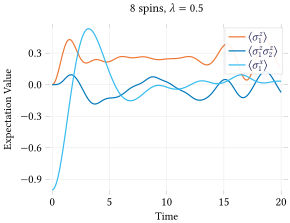

In [254]:
plot(xlabel="Time", ylabel="Expectation Value")
plot!(ts, hcat(fouts...)',
    title = latexstring("$N spins, \$\\lambda = $λ\$"),
    label = [
        L"\left\langle\pauli_1^z\right\rangle"
        L"\left\langle\pauli_1^z\pauli_2^z\right\rangle"
        L"\left\langle\pauli_1^x\right\rangle"
        ])